## In class Exercise 5
The purpose of this exercise is to practice different ML algorithms for text classification, text clustering, and model evaluation.

Hint: You might want to use the code demos from previous lectures, where suitable.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due tonight December 6th, 2023 at 11:59 PM.
**Late submissions cannot be considered.**

### Question 1.

The purpose of this question is to practice different machine learning algorithms for text classification, along with performance evaluation. In addition, you are requried to conduct *10 fold cross validation (https://scikit-learn.org/stable/modules/cross_validation.html)* in the training.

The dataset (see Canvas) contains two files train data and test data for sentiment analysis in IMDB review, and it has two categories: 1 represents positive and 0 represents negative.

You need to split the training data into training and validation data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model needs to be evaluated on the test data.

Algorithms:
1. MultinominalNB (2 points)
2. SVM (2 points)
3. KNN (2 points)
4. Decision tree (2 points)
5. Random Forest (2 points)
6. XGBoost (2 points)

Evaluation measurement:
1. Accuracy (2 points)
2. Recall (2 points)
3. Precison (2 points)
4. F-1 score (2 points)

In [8]:
# Write your code here
# Importing necessary libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Ignoring warnings during execution
warnings.filterwarnings('ignore')

# Function to read data from a file and extract text data and sentiments
def read_data(file_path):
    text_data, sentiments = [], []
    file_data = open(file_path).read()
    for i, j in enumerate(file_data.split("\n")):
        after_split = j.split(' ')
        text_data.append(" ".join(after_split[1:]))
        sentiments.append(after_split[0])
    return text_data, sentiments

# Function to preprocess data
def preprocess_data(data_frame):
    # Convert sentiment classes to integers
    data_frame['Sentimental Value'] = pd.to_numeric(data_frame['Sentimental Value'], errors='coerce')

    # Drop rows with NaN values in the target variable
    data_frame = data_frame.dropna(subset=['Sentimental Value'])

    # Pre-processing
    # Removal of special characters
    data_frame['After noise removal'] = data_frame['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

    # Removal of punctuation
    data_frame['Punctuation removal'] = data_frame['After noise removal'].str.replace('[^\w\s]', '')

    # Stopwords removal
    stop_word = stopwords.words('english')
    data_frame['Stopwords removal'] = data_frame['Punctuation removal'].apply(
        lambda x: " ".join(word for word in x.split() if word not in stop_word))

    # Lowercasing
    data_frame['Lower casing'] = data_frame['Stopwords removal'].apply(lambda x: " ".join(word.lower() for word in x.split()))

    return data_frame

# Function to vectorize data using TF-IDF
def vectorize_data(train_df, test_df):
    # TF-IDF Vectorization
    tfidf_vector = TfidfVectorizer(analyzer='word')
    tfidf_vector.fit(train_df['Lower casing'])
    x_train = tfidf_vector.transform(train_df['Lower casing'])
    tfidf_vector_test = TfidfVectorizer(analyzer='word', vocabulary=tfidf_vector.vocabulary_)
    tfidf_vector_test.fit(test_df['Lower casing'])
    x_test = tfidf_vector_test.transform(test_df['Lower casing'])

    return x_train, x_test

# Function to evaluate classifier performance
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    accuracy = accuracy_score(predicted, y_test)
    print(f"Accuracy of Training data ({classifier.__class__.__name__}): {accuracy}")

    predicted_testing = classifier.predict(x_test)
    accuracy_testing = accuracy_score(predicted_testing, y_test)
    print(f"Accuracy of Testing data ({classifier.__class__.__name__}): {accuracy_testing}")

    if 'XGB' not in str(classifier):
        scoring = 'accuracy'
        kfold = KFold(10, random_state=7, shuffle=True)
        cross_val = cross_val_score(classifier, x_test, y_test, cv=kfold, scoring=scoring).mean()
        print(f"Cross-validation score ({classifier.__class__.__name__}): {cross_val}")

    print(f"\nClassification Report ({classifier.__class__.__name__}):\n")
    print(classification_report(y_test, predicted))

# Reading data from files
training_text_data, training_sentiments = read_data('stsa-train.txt')
testing_text_data, testing_sentiments = read_data('stsa-test.txt')

# Creating data frames for training and testing data
training_df = pd.DataFrame(list(zip(training_sentiments, training_text_data)), columns=['Sentimental Value', 'Raw Data'])
testing_df = pd.DataFrame(list(zip(testing_sentiments, testing_text_data)), columns=['Sentimental Value', 'Raw Data'])

# Pre-processing data
training_df = preprocess_data(training_df)
testing_df = preprocess_data(testing_df)

# Vectorizing data
x_train, x_test = vectorize_data(training_df, testing_df)

# Splitting data for training and testing
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, training_df['Sentimental Value'],
                                                                      test_size=0.2, random_state=42)

# Ensuring target variables are integers
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

# List of classifiers to evaluate
classifiers = [
    naive_bayes.MultinomialNB(),
    svm.SVC(),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Evaluating each classifier
for classifier in classifiers:
    print(f"Evaluating {classifier.__class__.__name__}:")
    evaluate_classifier(classifier, x_train, y_train, x_valid, y_valid)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Evaluating MultinomialNB:
Accuracy of Training data (MultinomialNB): 0.7911849710982659
Accuracy of Testing data (MultinomialNB): 0.7911849710982659
Cross-validation score (MultinomialNB): 0.7015848191012408

Classification Report (MultinomialNB):

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       671
           1       0.75      0.89      0.81       713

    accuracy                           0.79      1384
   macro avg       0.80      0.79      0.79      1384
weighted avg       0.80      0.79      0.79      1384

Evaluating SVC:
Accuracy of Training data (SVC): 0.796242774566474
Accuracy of Testing data (SVC): 0.796242774566474
Cross-validation score (SVC): 0.7008758210822645

Classification Report (SVC):

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       671
           1       0.77      0.86      0.81       713

    accuracy                           0.80      1384
   macro 

### Question 2.

The purpose of the question is to practice different machine learning algorithms for text clustering.

Please downlad the dataset by using the following link: https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones

Apply the listed clustering methods to the dataset:
1. K-means (4 points)
2. DBSCAN (4 points)
3. Hierarchical clustering (4 points)
4. Word2Vec (4 points)
5. BERT (4 points)

In [10]:
#Write your code here.
#Write your code here.
# Import libraries
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
nltk.download('wordnet')

# Read data
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
print("Shape: {0}".format(df.shape))

# Data exploration
cluster_data_df = df.head(1000)
cluster_data_df







[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape: (413840, 6)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
995,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,It's a decent for the price.. I've had this on...,0.0
996,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,Is good cell phone,0.0
997,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,"Amazing phone. Cables and case included, also ...",0.0
998,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,Excelent,0.0


In [11]:
# Text preprocessing
from sklearn import metrics
cluster_data_df['After noise removal'] = cluster_data_df['Reviews'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', charctr) for charctr in x ))
cluster_data_df['Punctuation removal'] = cluster_data_df['After noise removal'].str.replace('[^\w\s]','')
cluster_data_df['Remove numbers'] = cluster_data_df['Punctuation removal'].str.replace('\d+', '')
stop_word = stopwords.words('english')
cluster_data_df['Stopwords removal'] = cluster_data_df['Remove numbers'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_word))
cluster_data_df['Lower casing'] = cluster_data_df['Stopwords removal'].apply(lambda x: " ".join(x.lower() for x in x.split()))
cluster_data_df['Tokenization'] = cluster_data_df['Lower casing'].apply(lambda x: TextBlob(x).words)
st = PorterStemmer()
cluster_data_df['Stemming'] = cluster_data_df['Tokenization'].apply(lambda x: " ".join([st.stem(word) for word in x]))
cluster_data_df['Lemmatization'] = cluster_data_df['Stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(cluster_data_df['Lemmatization'].values)

# K-Means Clustering
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters=10, random_state=99)
model_tf.fit(tfidf)
labels_tf = model_tf.labels_
cluster_center_tf = model_tf.cluster_centers_
terms1 = tfidf_vect.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
silhouette_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')


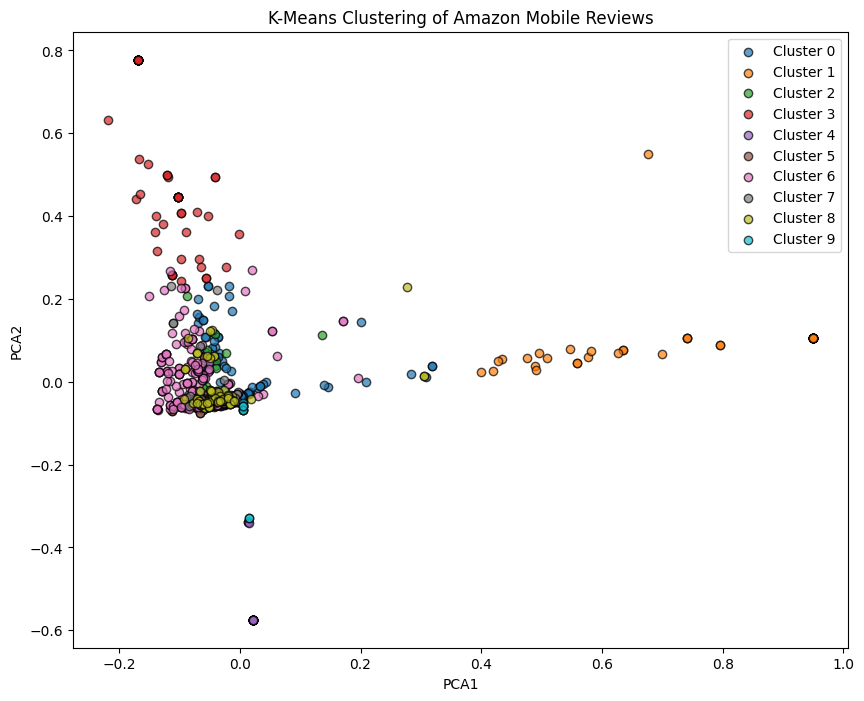

In [12]:
# Import libraries
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf.toarray())

# Create a DataFrame with the reduced features and cluster labels
cluster_data_pca = pd.DataFrame(tfidf_pca, columns=['PCA1', 'PCA2'])
cluster_data_pca['Cluster'] = labels_tf

# Plot clusters with customized colors
plt.figure(figsize=(10, 8))
for cluster in range(10):  # Adjust the range based on the number of clusters
    cluster_points = cluster_data_pca[cluster_data_pca['Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster}', alpha=0.7, edgecolors='k')

plt.title('K-Means Clustering of Amazon Mobile Reviews')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [13]:
# K-means - Method 2
# Generating bag of words features.
from sklearn.feature_extraction.text import CountVectorizer

# Creating bag of words (BoW) features
count_vect = CountVectorizer()
bow = count_vect.fit_transform(cluster_data_df['Reviews'].values)
print(f"BoW Shape: {bow.shape}")

# K-means clustering
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10, init='k-means++', random_state=99)
model.fit(bow)
labels = model.labels_
cluster_centers = model.cluster_centers_

# Silhouette Score
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bow, labels, metric='euclidean')
print(f"Silhouette Score: {silhouette_score}")

# Adding cluster labels to the dataframe
cluster_data_df['Bow Clus Label'] = model.labels_

# Displaying the first 2 rows of the dataframe
cluster_data_df.head(2)


BoW Shape: (1000, 3455)
Silhouette Score: 0.39528026327024723


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lower casing,Tokenization,Stemming,Lemmatization,Bow Clus Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel LUCKY found used phone us used hard pho...,i feel lucky found used phone us used hard pho...,"[i, feel, lucky, found, used, phone, us, used,...",i feel lucki found use phone us use hard phone...,i feel lucki found use phone u use hard phone ...,9
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice grade pantach revue Very clean...,nice phone nice grade pantach revue very clean...,"[nice, phone, nice, grade, pantach, revue, ver...",nice phone nice grade pantach revu veri clean ...,nice phone nice grade pantach revu veri clean ...,0


The two reviews assigned to cluster  0
----------------------------------------------------------------------
I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!


nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung


______________________________________________________________________
The two reviews assigned to cluster  1
----------------------------------------------------------------------
excelente


excelente


______________________________________________________________________
The two reviews assi

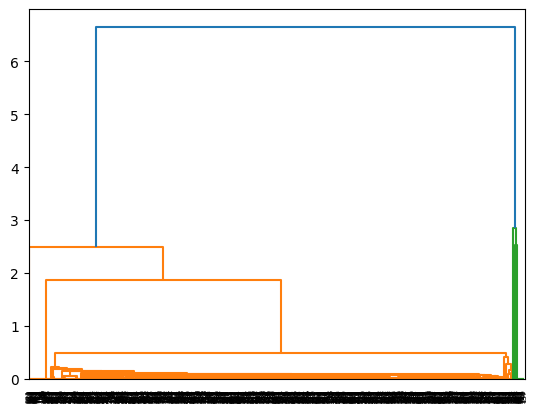

In [17]:
# DBSCAN clustering
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn import preprocessing
import numpy as np
import gensim
import scipy
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Set the minimum points for DBSCAN
minPts = 2 * 100

# Functions for computing lower bound and 200th nearest neighbor
def lower_bound(nums, target):
    # Implementation of binary search for lower bound
    l, r = 0, len(nums) - 1
    while l <= r:
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute_200th_nearest_neighbour(x, data):
    # Compute the 200th nearest neighbor distance
    dists = []
    for val in data:
        dist = np.sum((x - val) ** 2)
        if len(dists) == 200 and dists[199] > dist:
            l = int(lower_bound(dists, dist))
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    return dists[199]

# Prepare data for Word2Vec
list_of_trains_sent = list()
for i in cluster_data_df["Lower casing"].values:
    list_of_trains_sent.append(i.split())

# Create Word2Vec model
w2v_model = gensim.models.Word2Vec(list_of_trains_sent, vector_size=100, workers=4)

# Compute average Word2Vec vectors
list_of_sent_train = cluster_data_df['Lower casing'].apply(lambda x: x.split())
sent_vectors = []

for sent in list_of_sent_train:
    sent_vec = np.zeros(100)
    cnt_words = 1
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)

# Use scikit-learn preprocessing to normalize the vectors
sent_vectors = preprocessing.normalize(sent_vectors)

# Compute the 200th nearest neighbor distance for some points
two_hundredth_neighbour = []
for val in sent_vectors[:300]:
    two_hundredth_neighbour.append(compute_200th_nearest_neighbour(val, sent_vectors[:300]))

two_hundredth_neighbour.sort()

# Train DBSCAN model
model_dbscan = DBSCAN(eps=5, min_samples=minPts, n_jobs=-1)
model_dbscan.fit(sent_vectors)
cluster_data_df['AVG-W2V Clus Label'] = model_dbscan.labels_

# Hierarchical Clustering
# Generate hierarchical clustering dendrogram
dendro = hierarchy.dendrogram(hierarchy.linkage(sent_vectors, method='ward'))
plt.axhline(y=10)  # cut at 10 to get 5 clusters

# Agglomerative Clustering
# Train Agglomerative Clustering model
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg = cluster.fit_predict(sent_vectors)

# Assign labels/clusters to each point/text
aggdfa = cluster_data_df
aggdfa['AVG-W2V Clus Label'] = cluster.labels_

# Count of points belonging to each cluster
aggdfa.groupby(['AVG-W2V Clus Label'])['Reviews'].count()

# Display reviews assigned to each cluster
for i in range(5):
    print("The two reviews assigned to cluster ", i)
    print("-" * 70)
    for j in [0, 1]:
        print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][j]]['Reviews'])
        print('\n')
    print("_" * 70)


In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.

In [ ]:
#You can write you answer here. (No code needed)

'''
The clustering algorithms K-means, DBSCAN, and Hierarchical clustering follow distinct approaches in handling text data.
K-means partitions data into predefined clusters, DBSCAN identifies dense regions and outliers, and Hierarchical clustering forms a hierarchical tree structure of clusters.
In contrast, Word2Vec captures semantic relationships among words in a continuous vector space, offering nuanced representations, albeit without an explicit clustering design.
 BERT, a state-of-the-art transformer-based model, excels in contextualized embeddings, but its computational demands may be a concern.
 Each method caters to different aspects of clustering and text representation, ranging from traditional algorithms to advanced models that emphasize capturing intricate semantic meanings and contextual embeddings.
'''


